> Code to accompany **Chapter 5: The Principles of Adversarial Input**

# Saliency Maps using ResNet and keras-vis

This Jupyter notebook illustrates the use of saliency maps to establish the most important aspects of an image to the predictions made by a DNN.

We'll use the [Keras Visualization Toolkit](https://github.com/raghakot/keras-vis).

## Import the pre-trained ResNet50 Model

In [1]:
# Import the model
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import ResNet50

# Access helper function
import sys
sys.path.append('..')
from strengtheningdnns.image_utils import image_from_file

# Get the ResNet50 network using the imagenet trained weights
model = ResNet50(weights='imagenet', include_top=True)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


## Select our image and get its predictions

First select the image and resize it.


In [2]:

image_path = '../images/clock.jpg'
#image_path = '../images/cake.jpg'
#image_path = '../images/cake_zoom.jpg'


image = image_from_file(image_path, [224,224])

(?, ?, ?)
Re-scaling image to  [224, 224]


We need to pre-process images before they are passed to the classifier. 

If you are interested in understanding this pre-processing step in greater detail, take a look in [chapter04/ResNet50Preprocessing.ipynb](../chapter04/resnet50_preprocessing.ipynb).

In [3]:
from keras.applications.resnet50 import preprocess_input
image_for_resnet = preprocess_input(image)

Get the ResNet50 predictions.

ResNet50 takes a batch of images as input. expand_dims inserts a new axis into the numpy array representing the image so it becomes one of a list (containing only one image).



In [4]:
from keras.applications.resnet50 import decode_predictions
import numpy as np

image_for_resnet_list = np.expand_dims(image_for_resnet, 0)


decoded_predictions = decode_predictions(model.predict(image_for_resnet_list), top=3)
label = np.argmax(model.predict(image_for_resnet_list))

for pred in decoded_predictions[0]:
    print(pred[1], ':', pred[2])


analog_clock : 0.49137956
wall_clock : 0.46333772
barometer : 0.015819294


## Visualise Saliency using Keras-vis 

The gradients are extracted based on the output logits (returned prior to the softmax layer). The following code gets this output layer from the ResNet50 model.

In [5]:
from vis.utils import utils
from keras import activations

layer_idx = utils.find_layer_idx(model, 'fc1000')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

C:\Users\katyw\Anaconda3\envs\strengthening-dnns\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Next, get the gradients using Keras-vis visualize_saliency.

Note that we pass the predicted label to this funtion. This ensures that the partial derivitive is calculated wrt that label - hence we see the gradients that are most important in calculating the target label.

In [6]:
from vis.visualization import visualize_saliency
grads = visualize_saliency(model, 
                           layer_idx, 
                           filter_indices=label, 
                           seed_input=image_for_resnet, 
                           backprop_modifier='guided')

Instructions for updating:
Use tf.cast instead.


Plot the original image alongside the saliency map.

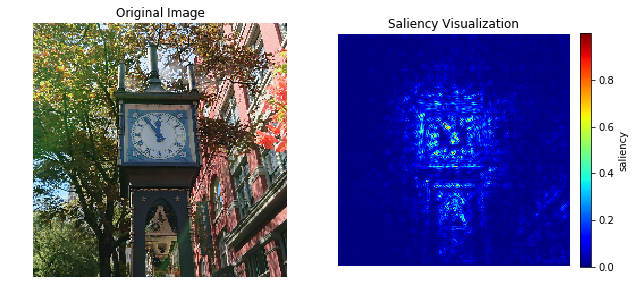

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))


plt.subplot(1,2, 1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(image) 

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Saliency Visualization')
plt.imshow(grads, cmap='jet') 
cb = plt.colorbar(fraction=0.046, pad=0.04) 
cb.set_label('saliency')
plt.show()

## Visualising with visualize_cam

In [8]:
from vis.visualization import visualize_cam

heatmap = visualize_cam(model, 
                        layer_idx, 
                        filter_indices=label, 
                        seed_input=image_for_resnet)


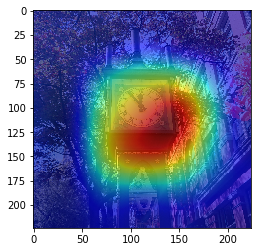

In [9]:
plt.imshow(image)    
plt.imshow(heatmap, cmap='jet', alpha = 0.6)
plt.show()
